In [1]:
import pandas
import numpy

In [2]:
df = pandas.read_csv("income_data.csv", skipinitialspace=True)

# Laplace mechanism

<AxesSubplot:ylabel='Frequency'>

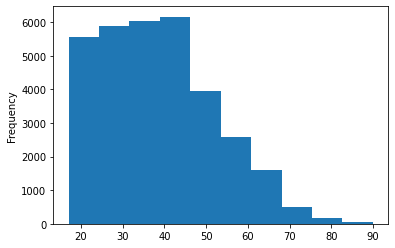

In [4]:
df['age'].plot.hist()

In [8]:
# how many individuals are over 50 years of age
(df['age'] > 50).sum()

6460

In [9]:
# let's construct a Laplace mechanism
sensitivity = 1
epsilon = 0.1
(df['age'] > 50).sum() + numpy.random.laplace(0, sensitivity/epsilon)

6453.248002244163

In [10]:
import matplotlib.pyplot as plt

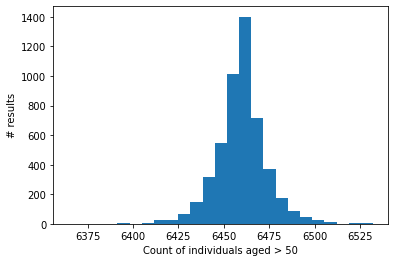

In [15]:
draws = (df['age'] > 50).sum() + numpy.random.laplace(0, sensitivity/epsilon, size=5000)
plt.hist(draws, bins=25)
plt.xlabel('Count of individuals aged > 50')
plt.ylabel('# results')
None

In [17]:
df['target'] # 1 is high, 0 is low

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: target, Length: 32561, dtype: int64

In [19]:
# what's the fraction of > 50 year olds in high income bracket
(df['target'][df['age'] > 50]).mean()

0.32476780185758514

In [20]:
df['target'].mean()

0.2408095574460244

<AxesSubplot:ylabel='Frequency'>

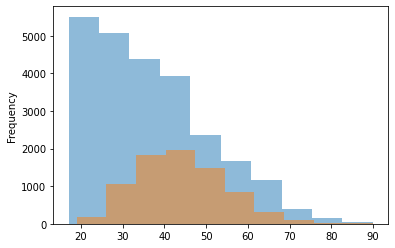

In [23]:
df['age'][df['target'] == 0].plot.hist(alpha=0.5)
df['age'][df['target'] == 1].plot.hist(alpha=0.5)

In [24]:
# one step in decision tree
for split in sorted(df['age'].unique()):
    mask = df['age'] < split
    gini = 1 - df['target'][mask].mean()**2 - df['target'][~mask].mean()**2
    print(split, gini)

17 nan
18 0.9405777910027132
19 0.9384923602700396
20 0.9356569309712002
21 0.9324037953289761
22 0.9291084535217413
23 0.9255033081539082
24 0.9209531381616114
25 0.9167953282040779
26 0.9123708976758473
27 0.9081011930609675
28 0.9034055585766496
29 0.8987093124655844
30 0.8943262796951301
31 0.8898414094888842
32 0.8850061255889431
33 0.8805648785318232
34 0.8754301603056232
35 0.871007575834008
36 0.8658981157616767
37 0.8614150932908136
38 0.858128273849205
39 0.8549995515821888
40 0.8519378859257979
41 0.8489007035802763
42 0.8460635676819106
43 0.8433930866024986
44 0.8410950785634167
45 0.8402576539823484
46 0.8398991904732238
47 0.8401216498666478
48 0.8413276907901563
49 0.8424367464286244
50 0.8421961837321345
51 0.8461127250620468
52 0.8495956031588124
53 0.852914728362183
54 0.8571771837724582
55 0.8622500335675106
56 0.8649479012986865
57 0.8666157217008469
58 0.8709430882886444
59 0.8745144536050528
60 0.8814471751017964
61 0.8860150301966733
62 0.8913290210899718
63 0.8

# Exponential Mechanism

In [25]:
df['education'].unique() # R

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [26]:
df['education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [29]:
# scoring function for the query 'most common education'
def u(x, value):
    v_cnts = x.value_counts()
    return v_cnts[value] / v_cnts.sum()

In [30]:
u(df['education'], 'Some-college')

0.22391818433094807

In [33]:
df['education'].drop(2)

0         Bachelors
1         Bachelors
3              11th
4         Bachelors
5           Masters
            ...    
32556    Assoc-acdm
32557       HS-grad
32558       HS-grad
32559       HS-grad
32560       HS-grad
Name: education, Length: 32560, dtype: object

In [35]:
df['education'].shape[0]

32561

In [37]:
answers = []
for _ in range(1000):
    drop = numpy.random.choice(df['education'].shape[0])
    xp = df['education'].drop(drop)
    answers.append(numpy.abs(u(df['education'], 'Some-college') - u(xp, 'Some-college')))

In [40]:
numpy.unique(answers)

array([6.87709411e-06, 2.38354366e-05])

In [41]:
u(df['education'], numpy.array(['Some-college', 'HS-grad']))

Some-college    0.223918
HS-grad         0.322502
Name: education, dtype: float64

In [42]:
def exponential(x, R, u, sensitivity, epsilon, n=1):
    scores = u(x, R) # score each element in R
    probs = numpy.exp(epsilon*scores / 2 / sensitivity)
    probs /= probs.sum()
    return numpy.random.choice(R, n, p=probs)

In [50]:
exponential(df['education'], df['education'].unique(), u, 1, 1)

array(['9th'], dtype=object)

In [52]:
import pandas

<AxesSubplot:>

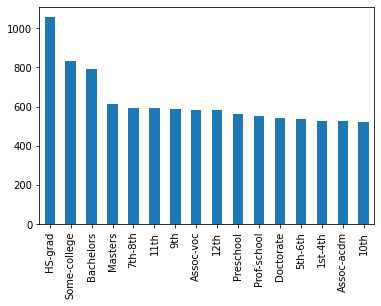

In [68]:
pandas.Series(exponential(df['education'], df['education'].unique(), u, 1, 4, 10000)
             ).value_counts().plot.bar()

<AxesSubplot:>

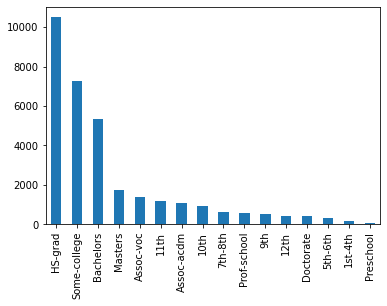

In [56]:
df['education'].value_counts().plot.bar()

# Differential Privacy Library

https://diffprivlib.readthedocs.io/en/latest/index.html

In [69]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'target'],
      dtype='object')

In [72]:
from diffprivlib.models import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

In [81]:
def mk_model(epsilon):
    return Pipeline([
        ('process', ColumnTransformer([
            ('one-hot', OneHotEncoder(drop='first', sparse=False), ['education', 'sex']), # careful!
            ('leave-age', FunctionTransformer(), ['age'])
        ])),
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(data_norm=50, epsilon=epsilon))
    ])

In [82]:
mk_model(0.5).fit(df, df['target'])

Pipeline(steps=[('process',
                 ColumnTransformer(transformers=[('one-hot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['education', 'sex']),
                                                 ('leave-age',
                                                  FunctionTransformer(),
                                                  ['age'])])),
                ('scale', StandardScaler()),
                ('clf',
                 LogisticRegression(accountant=BudgetAccountant(spent_budget=[(0.5, 0)]),
                                    data_norm=50, epsilon=0.5))])

In [83]:
eps = numpy.linspace(0.1, 2, 10)
scores = [cross_val_score(mk_model(e), df, df['target']) for e in eps]

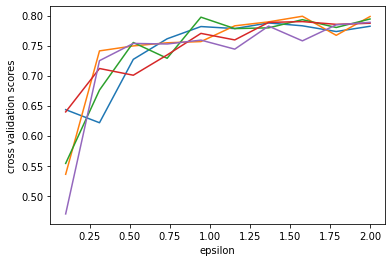

In [86]:
plt.plot(eps, scores)
plt.xlabel('epsilon')
plt.ylabel('cross validation scores')
None